In [1]:
import numpy as np
import tensorflow as tf

## Setting up a simple meta-learning environment

First, we set up a meta-learning environment from which we can generate tasks/datasets for meta-training and meta-testing. In particular, we use sinusoid functions with random amplitude and phase shift. Each task corresponds to a sinusoidal function $f_{a,b}(x)$, given as follows:

$$ f_{a,b}(x) = a \sin(x-b) + 5, ~\text{with}~~ a \sim \mathit{U}(2, 4), b \sim \mathit{U}(-2, 2)$$

Given $f_{a,b}(x)$, the data $S = \{(x_1, y_1), ...., (x_m, y_m) \}$ is generated as follows:

$$x_j \sim \mathit{U}(-4, 4), y = f_{a,b}(x_j)) + \epsilon_j ~, ~~ \epsilon_j \sim \mathcal{N}(0, 0.1^2) ~~ \text{for} ~j= 1, ..., m$$

In [2]:
class SinusoidEnv():
    
    def __init__(self, amp_low=2.0, amp_high=4.0, x_shift_low=-2.0, x_shift_high=2.0,
                 x_low=-4.0, x_high=4.0, noise_std=0.1, seed=234):
        self.amp_low = amp_low
        self.amp_high = amp_high
        self.x_shift_low = x_shift_low
        self.x_shift_high = x_shift_high
        self.x_low = x_low
        self.x_high = x_high
        self.noise_std = noise_std
        self.random_state = np.random.RandomState(seed)

    def _sample_sinusoid_fn(self):
        amplitude = np.random.uniform(self.amp_low, self.amp_high)
        x_shift = np.random.uniform(self.x_shift_low, self.x_shift_high)
        return lambda x: amplitude * np.sin((x - x_shift)) + 5.0

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples_context + n_samples_test, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples

### Generate meta-train and meta-test data

For each task the learner gets only 5 training points. For evaluation, we use 200 points.

In [3]:
env = SinusoidEnv()
meta_train_data = env.generate_meta_train_data(n_tasks=100, n_samples=5)
meta_test_data = env.generate_meta_test_data(n_tasks=20, n_samples_context=5,n_samples_test=200)

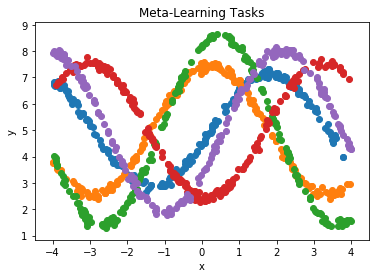

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
for x_context, y_context, x_test, y_test in meta_test_data[:5]:
    plt.scatter(x_test, y_test)
plt.title('Meta-Learning Tasks')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Training a Standard Bayesian Neural Network 

Now, we train a standard Bayesian Neural Network (BNN) with zero-centered, sperical Gaussian prior $P(\theta) = \mathcal{N}(0, \sigma_P^2 \mathbf{I})$.

100%|██████████| 500/500 [00:02<00:00, 180.01it/s, loss=53.3, avg_ll=-30.2, avg_rmse=1.85, cal_err=0.213]


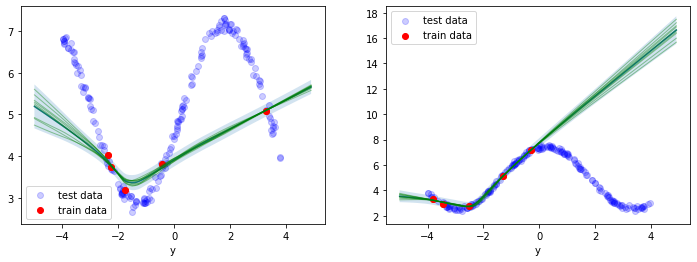

In [5]:
import warnings
import warnings
warnings.filterwarnings("ignore")

from pacoh_nn.bnn import BayesianNeuralNetworkSVGD

fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # setting up and fitting the BNN
    bnn = BayesianNeuralNetworkSVGD(x_context, y_context, hidden_layer_sizes=(64, 64), prior_weight=0.001, bandwidth=1000.0)
    bnn.fit(x_val=x_test, y_val=y_test, num_iter_fit=500, log_period=500)
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    bnn.plot_predictions(x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

Since this prior is pretty uninformative, it provides poor inductive bias. As we can see in the plots below, the learned posterior prediction do not generalize well beyond the training data. Moreover, the majority of test points lie outside the confidence regions of the posterior, indicating poorly calibrated uncertainty estimates.

## Meta-Learning a BNN Prior with PACOH-NN

### Meta-Training

Now, we use PACOH-NN to meta-learn a prior that exhibits the inductive bias our sinusoidal environment. During the meta-training process, we plot functions sampled from the (learned) prior to visually inspect how the prior evolves.

Start meta-training -------------------- 


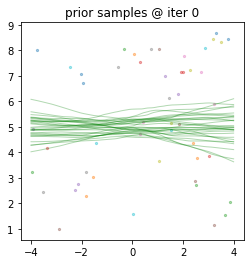


Iter 0/20000 - Time 34.06 sec - Train-Loss: -6892.69922

Iter 1000/20000 - Time 16.27 sec - Train-Loss: -347.28662

Iter 2000/20000 - Time 16.66 sec - Train-Loss: -568.88226

Iter 3000/20000 - Time 16.91 sec - Train-Loss: -368.60474

Iter 4000/20000 - Time 16.24 sec - Train-Loss: -385.80051


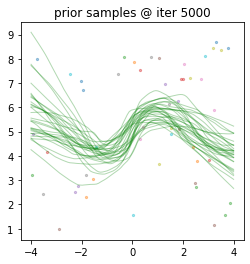

	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----

Iter 5000/20000 - Time 17.72 sec - Train-Loss: -312.35294- Val-avg_ll: -11.791 +- 19.921- Val-avg_rmse: 1.050 +- 0.412- Val-cal_err: 0.213 +- 0.074

Iter 6000/20000 - Time 36.87 sec - Train-Loss: -251.22639

Iter 7000/20000 - Time 17.88 sec - Train-Loss: -183.28075

Iter 8000/20000 - Time 17.71 sec - Train-Loss: -108.43472

Iter 9000/20000 - Time 17.23 sec - Train-Loss: -81.92619


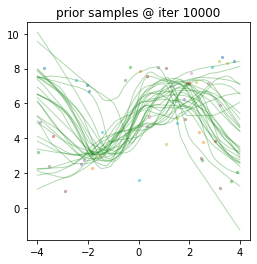

	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 19.84 sec - Train-Loss: -54.15375- Val-avg_ll: -1.148 +- 0.245- Val-avg_rmse: 0.803 +- 0.284- Val-cal_err: 0.121 +- 0.045

Iter 11000/20000 - Time 40.77 sec - Train-Loss: -42.42611

Iter 12000/20000 - Time 21.16 sec - Train-Loss: -41.27357

Iter 13000/20000 - Time 21.18 sec - Train-Loss: -43.88357

Iter 14000/20000 - Time 18.46 sec - Train-Loss: -39.46857


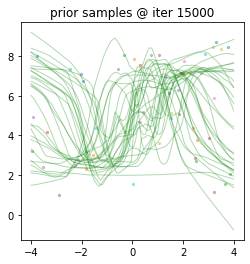

	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----

Iter 15000/20000 - Time 21.21 sec - Train-Loss: -40.96516- Val-avg_ll: -1.234 +- 0.158- Val-avg_rmse: 0.801 +- 0.232- Val-cal_err: 0.122 +- 0.034

Iter 16000/20000 - Time 36.43 sec - Train-Loss: -39.00370

Iter 17000/20000 - Time 17.23 sec - Train-Loss: -33.43497

Iter 18000/20000 - Time 21.42 sec - Train-Loss: -42.24810

Iter 19000/20000 - Time 18.06 sec - Train-Loss: -35.82774


In [6]:
from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, random_seed=22, num_iter_meta_train=20001,
                                     learn_likelihood=True, likelihood_std=0.1)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=5000, log_period=1000, 
                        plot_prior_during_training=True, plot_period=5000)

As we can see in the plots this is actually the case. Throughout the process of meta-training, PACOH-NN meta-learns inductive bias towards sinusoidal function shapes.

### Meta-Testing

Finally, we perform meta-testing to see whether our meta-learned prior actually improves the BNN posterior predictions.

100%|██████████| 3000/3000 [00:22<00:00, 135.76it/s, loss=-60.3]


	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
avg_ll: -1.6232 +- 0.3389
avg_rmse: 1.1390 +- 0.3377
cal_err: 0.1332 +- 0.0536


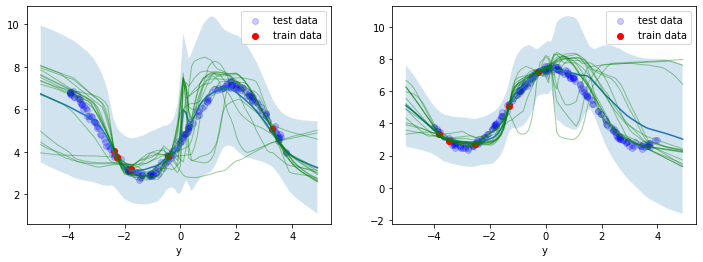

In [7]:
pacoh_model.num_iter_meta_test = 3000
pacoh_model.prior_weight = 0.01
fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    pacoh_model.plot_posterior(x_context, y_context, x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f"%(key, eval_metrics_mean[key], eval_metrics_std[key]))

Now the posterior prediction generalize much better beyond the training data. 
Moreover, the confidence intervals of the posterior contain the test points. 
Overall, this suggests that the meta-learned prior conveys useful inductive bias.